In [1]:
! pip install transformers datasets pytorch_metric_learning faiss-gpu umap-learn

  Using cached faiss-gpu-1.7.1.post2.tar.gz (40 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz#sha256=877478752c03678fd9b9553e4ffadca82cd337bba9bb6a939aa1c6ea561a7a58 (from https://pypi.org/simple/faiss-gpu/): Requested faiss-cpu from https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz#sha256=877478752c03678fd9b9553e4ffadca82cd337bba9bb6a939aa1c6ea561a7a58 has inconsistent name: filename has 'faiss-gpu', but metadata has 'faiss-cpu'
  Using cached faiss-gpu-1.7.1.post1.tar.gz (41 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/39/8d/b62bc92c8dd4b2a99d4a06b8804280f6445748b6d698eabb037e111080c7/f

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [7 lines of output]
      running egg_info
      creating C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-ojtam29r\faiss_cpu.egg-info
      writing C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-ojtam29r\faiss_cpu.egg-info\PKG-INFO
      writing dependency_links to C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-ojtam29r\faiss_cpu.egg-info\dependency_links.txt
      writing top-level names to C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-ojtam29r\faiss_cpu.egg-info\top_level.txt
      writing manifest file 'C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-ojtam29r\faiss_cpu.egg-info\SOURCES.txt'
      error: package directory 'C:\Users\tomma\AppData\Local\Temp\pip-install-renlu1pz\faiss-gpu_39dc08a1dc9548e0a17ebfe414e1ae43\faiss\faiss\python' does not exist
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a pr

In [2]:
# ! wget https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data.json

## Preliminary Steps

In [3]:
from datasets import load_dataset
import numpy as np
import re
from matplotlib import pyplot as plt



dataset = load_dataset('json',data_files='data.json').class_encode_column('artist')
artists_mappings = dataset['train'].features['artist'].names

c:\Users\tomma\Documents\Uni\Magistrale\pyvenvs\ML_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration default-1a5eae679f892839
Found cached dataset json (C:/Users/tomma/.cache/huggingface/datasets/json/default-1a5eae679f892839/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
100%|██████████| 1/1 [00:00<00:00, 17.72it/s]
Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-425175bc9efee20d.arrow


In [4]:
def clean(example):
    allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
    for part in allowed_parts:
        example['lyrics']=re.sub("\[.*"+part+".*\]", f"[{part}]", example['lyrics'], flags=re.IGNORECASE)
    example['lyrics']=re.sub("\[(?!"+"|".join(allowed_parts)+").*?\]", "", example['lyrics'], flags=re.DOTALL)
    example['lyrics']=re.sub("[0-9]+embed", "", example['lyrics'], flags=re.IGNORECASE)
    return example

mapped_dataset = dataset.map(clean)


Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-0e48b86a0e902a4f.arrow


In [5]:
def list_song_parts(example):
    parts = re.findall(r'\[[^\[\]]+\]',example['lyrics']) # Capture everything enclosed in square brackets
    for i,part in enumerate(parts): 
        parts[i] = re.sub(r':.*(?=\])','',part) # Remove everything from : to the closing bracket ] (Most lyrics contain the name of the singer of these parts e.g. [Chorus: 2 Chainz])
    return {'parts': parts}
parts = mapped_dataset['train'].map(list_song_parts,remove_columns=dataset['train'].column_names)

parts:np.ndarray = np.unique([el for l in parts['parts'] for el in l ])

Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-6bc066ed08a9cf98.arrow


In [6]:
print(*parts)

[break] [bridge] [chorus] [interlude] [intro] [outro] [verse]


In [7]:
# print(mapped_dataset)
print(dataset['train'][1000]['lyrics'])
print("----------------")
print(mapped_dataset['train'][1000]['lyrics'])

XO TOUR Llif3 Lyrics[Intro]
Are you alright?
I'm alright, I'm quite alright
And my money's right
8… (Yeah)
Countin' them bands
All way to the top 'til they be fallin' over
(Yeah, yeah, yeah)
Countin' them bands
On my way to the top 'til we fallin' over

[Chorus]
I don't really care if you cry
On the real, you shoulda never lied
Shoulda saw the way she looked me in my eyes
She said, "Baby, I am not afraid to die"
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge

[Verse 1]
Phantom that's all red, inside all white
Like somethin' you ride a sled down, I just want that head
My Brittany got mad, I'm barely her man now
Everybody got the same swag now
Watch the way that I tear it down
Stackin' my bands all the way to the top
All the way 'til my bands fallin' over
Every time that you leave your spot
Your girlfriend call me like, "Come on over!"
I like the way that she treat me
Gon' leave you, 

In [8]:
allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
def contains_one_of(allowed_parts,part:str):
    for p in allowed_parts:
        if p in part.lower(): return True
    return False
filtered_parts = np.unique([part for part in parts if contains_one_of(allowed_parts,part)])

In [9]:
sorted(filtered_parts)

['[break]',
 '[bridge]',
 '[chorus]',
 '[interlude]',
 '[intro]',
 '[outro]',
 '[verse]']

# Preprocessing

In [10]:
def plot_dist(dataset):
    counts = {}
    for example in dataset:
        if example['artist'] not in counts.keys():
            counts[example['artist']] = 0
        else:
            counts[example['artist']] += 1
    plt.bar(counts.keys(), counts.values())

## Train Test Val Split

In [11]:
from datasets import DatasetDict
tts_mapped_dataset = mapped_dataset['train'].train_test_split(train_size=0.7)
mapped_dataset_valid = tts_mapped_dataset['test'].train_test_split(train_size=0.3)

train_test_val_dataset = DatasetDict({
    'train': tts_mapped_dataset['train'],
    'test':mapped_dataset_valid['test'],
    'val': mapped_dataset_valid['train']
    
})
train_test_val_dataset_filtered = train_test_val_dataset.filter(lambda example: example["artist"]<10)
train_test_val_dataset_filtered

100%|██████████| 1/1 [00:00<00:00, 48.63ba/s]


DatasetDict({
    train: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 714
    })
    test: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 201
    })
    val: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 85
    })
})

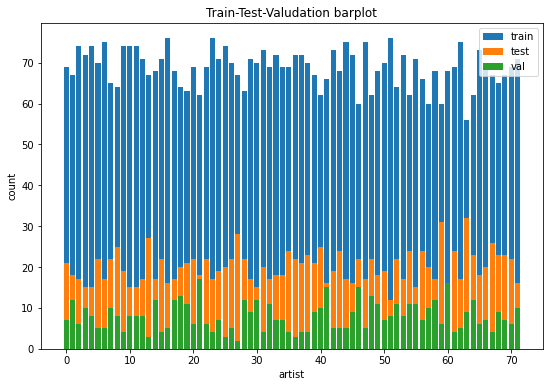

In [12]:
plt.figure(figsize=(9,6))
plt.title("Train-Test-Valudation barplot")
plt.ylabel("count")
plt.xlabel("artist")
plot_dist(train_test_val_dataset['train'])
plot_dist(train_test_val_dataset['test'])
plot_dist(train_test_val_dataset['val'])
plt.legend(['train', 'test', 'val'])
plt.show()

# Machine Learning

In [13]:
from transformers import AutoModel, AutoTokenizer

# Language Model Declaration:

modelckpt="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(modelckpt)

In [34]:
# Tokenize
def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples['lyrics'],
        truncation=True,
        padding=True,
        max_length=512
        )
    tokenized_examples['labels'] = examples['artist']
    return tokenized_examples

# train_features = train_test_val_dataset['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
# test_features = train_test_val_dataset['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
# val_features = train_test_val_dataset['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

train_features = train_test_val_dataset_filtered['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
test_features = train_test_val_dataset_filtered['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
val_features = train_test_val_dataset_filtered['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

100%|██████████| 1/1 [00:00<00:00,  1.36ba/s]
Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-5f9fa7ab508f2ac9.arrow
Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-7a39af9fab62b8f0.arrow


In [35]:
from cycler import cycler

def visualize_embeddings(embeddings, labels):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  plt.figure(figsize=(20,15))
  plt.gca().set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0,0.9, num_classes)]
      )
  )

  for i in range(num_classes):
    idx = (labels==label_set[i])
    plt.plot(embeddings[idx,0], embeddings[idx,1], ".", markersize=10, label=i)
  #plt.legend(loc="best", markerscale=10)
  plt.show()

In [91]:
from pytorch_metric_learning.samplers import MPerClassSampler
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset):
    def __init__(self,dataset) -> None:
        super().__init__()
        self.dataset = dataset
    def __getitem__(self, index):
        index = int(index)
        return (self.dataset[index]['input_ids'],self.dataset[index]['attention_mask']),self.dataset[index]['labels']
    def __len__(self):
        return len(self.dataset)

labels = [int(label) for label in train_features['labels']]
m = 5
batch_size=len(np.unique(labels))*m

sampler = MPerClassSampler(labels, m, batch_size=batch_size, length_before_new_iter=100)


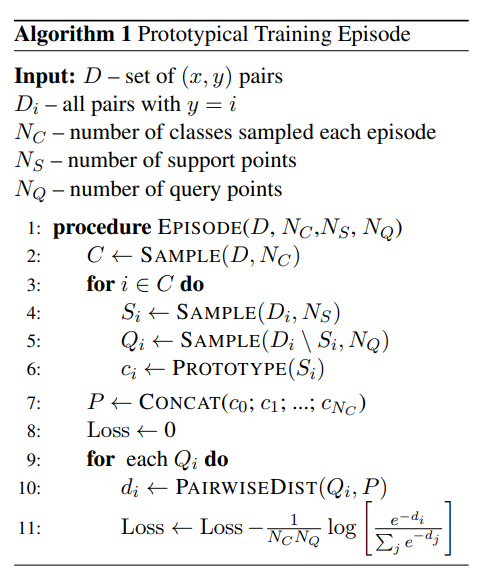](attachment:image.png)

In [101]:
from tqdm import tqdm

dataloader = DataLoader(MyDataset(train_features),sampler=sampler,batch_size=batch_size)

def train(model,dataloader):
    for batch_idx,((input_ids,attention_mask), label) in enumerate(tqdm(dataloader)):
        break        
train(None,dataloader)

  0%|          | 0/2000 [00:00<?, ?it/s]


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
from torch import Tensor
from typing import Optional,Union,Tuple, Dict, Any


class PrototypeLearningTransformerModel(torch.nn.Module):
    def __init__(self,
                 model_ckpt: str,
                 output_dim: int) -> None:
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_ckpt)
        self.dense_layer = torch.nn.Linear(self.transformer.config.hidden_size, output_dim)

    def compute_prototypes(self, support: Tensor, label: Tensor) -> Tensor:
        """Set the current prototypes used for classification.

        Parameters
        ----------
        data : torch.Tensor
            Input encodings
        label : torch.Tensor
            Corresponding labels

        """
        means_dict: Dict[int, Any] = {}
        for i in range(support.size(0)):
            means_dict.setdefault(int(label[i]), []).append(support[i])

        means = []
        n_means = len(means_dict)

        for i in range(n_means):
            # Ensure that all contiguous indices are in the means dict
            supports = torch.stack(means_dict[i], dim=0)
            if supports.size(0) > 1:
                mean = supports.mean(0).squeeze(0)
            else:
                mean = supports.squeeze(0)
            means.append(mean)

        prototypes = torch.stack(means, dim=0)
        return prototypes

    def forward(self,  # type: ignore
                query_input_ids: Tensor,
                query_attention_mask: Tensor,
                support_input_ids: Optional[Tensor] = None,
                support_attention_mask: Optional[Tensor] = None,
                support_label: Optional[Tensor] = None,
                prototypes: Optional[Tensor] = None) -> Union[Tensor, Tuple[Tensor, Tensor]]:
        """Run a forward pass through the network.
        
        Parameters
        ----------
        query: Tensor
            The query examples, as tensor of shape (seq_len x batch_size)
        support: Tensor
            The support examples, as tensor of shape (seq_len x batch_size)
        support_label: Tensor
            The support labels, as tensor of shape (batch_size)

        Returns
        -------
        Tensor
            If query labels are

        """
        query_embedding = self.transformer(query_input_ids, query_attention_mask)
        query_encoding = torch.nn.functional.relu(self.dense_layer(query_embedding["pooler_output"]))
    
        if prototypes is not None:
            prototypes = prototypes
        elif support_input_ids is not None and support_attention_mask is not None and support_label is not None:

            support_embedding = self.transformer(input_ids=support_input_ids, attention_mask=support_attention_mask)
            support_encoding = torch.nn.functional.relu(self.dense_layer(support_embedding["pooler_output"]))

            prototypes = self.compute_prototypes(support_encoding, support_label)
        else:
            raise ValueError("No prototypes set or provided")


        dist = self.__euclidean_distance__(query_encoding, prototypes)
        return - dist
    
    def __euclidean_distance__( mat_1: Tensor, mat_2: Tensor):
        _dist = [torch.sum((mat_1 - mat_2[i])**2, dim=1) for i in range(mat_2.size(0))]
        dist = torch.stack(_dist, dim=1)
        return dist